In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook


We here minimize the quadratic $$f(x,y)=x^2+5y^2$$ which has Eigenspace $v_1=(0,1)$ and $v_2=(1,0)$ with eigenvalues $\lambda_1=10$ and $\lambda_2=2$. 

Thus the $\textit{locally}$ optimal step size for $\textbf{GD}$ is $\alpha_1=1/10$ while the $\textit{globally}$ optimal step size is $\alpha_2=2/(10+2)=1/6$. The problem with the greedy step size $\alpha_1$ is that it exploits eigendirections of small eigenvalues such as $v_2$ very slowly (since the gradient has a small component along them), while it minimizes the first dimension $v_1$ within 1 step. Therefore, $\alpha_2$ is tied towards minimizing the distance $x_k-x^*$ in all dimensions equally well in dimensions.

Ideally, you would rescale $\textit{each}$ dimension of the gradient $\textit{seperatly}$ by $1/\lambda_i$ which is exactly what $\textbf{Newton's Method}$ does.

For $\textbf{AGD}$ the optimal step-size is $\alpha= 1/10$ and the optimal momentum parameter $\beta=(\sqrt{\kappa}-1)/(\sqrt{\kappa}+1))$ with $\kappa=10/2$.

In general momentum buys us progress in directions to $x^*$ that have low gradient component at the cost of a) not exploiting large components optimally in each step b) maybe even ascending. 

Here this comes for free since the first step already optimizes one dimension fully and then we simply exploit the low (positive) curvature direction on the bottom of the valley faster. 

### Run methods

<IPython.core.display.Javascript object>


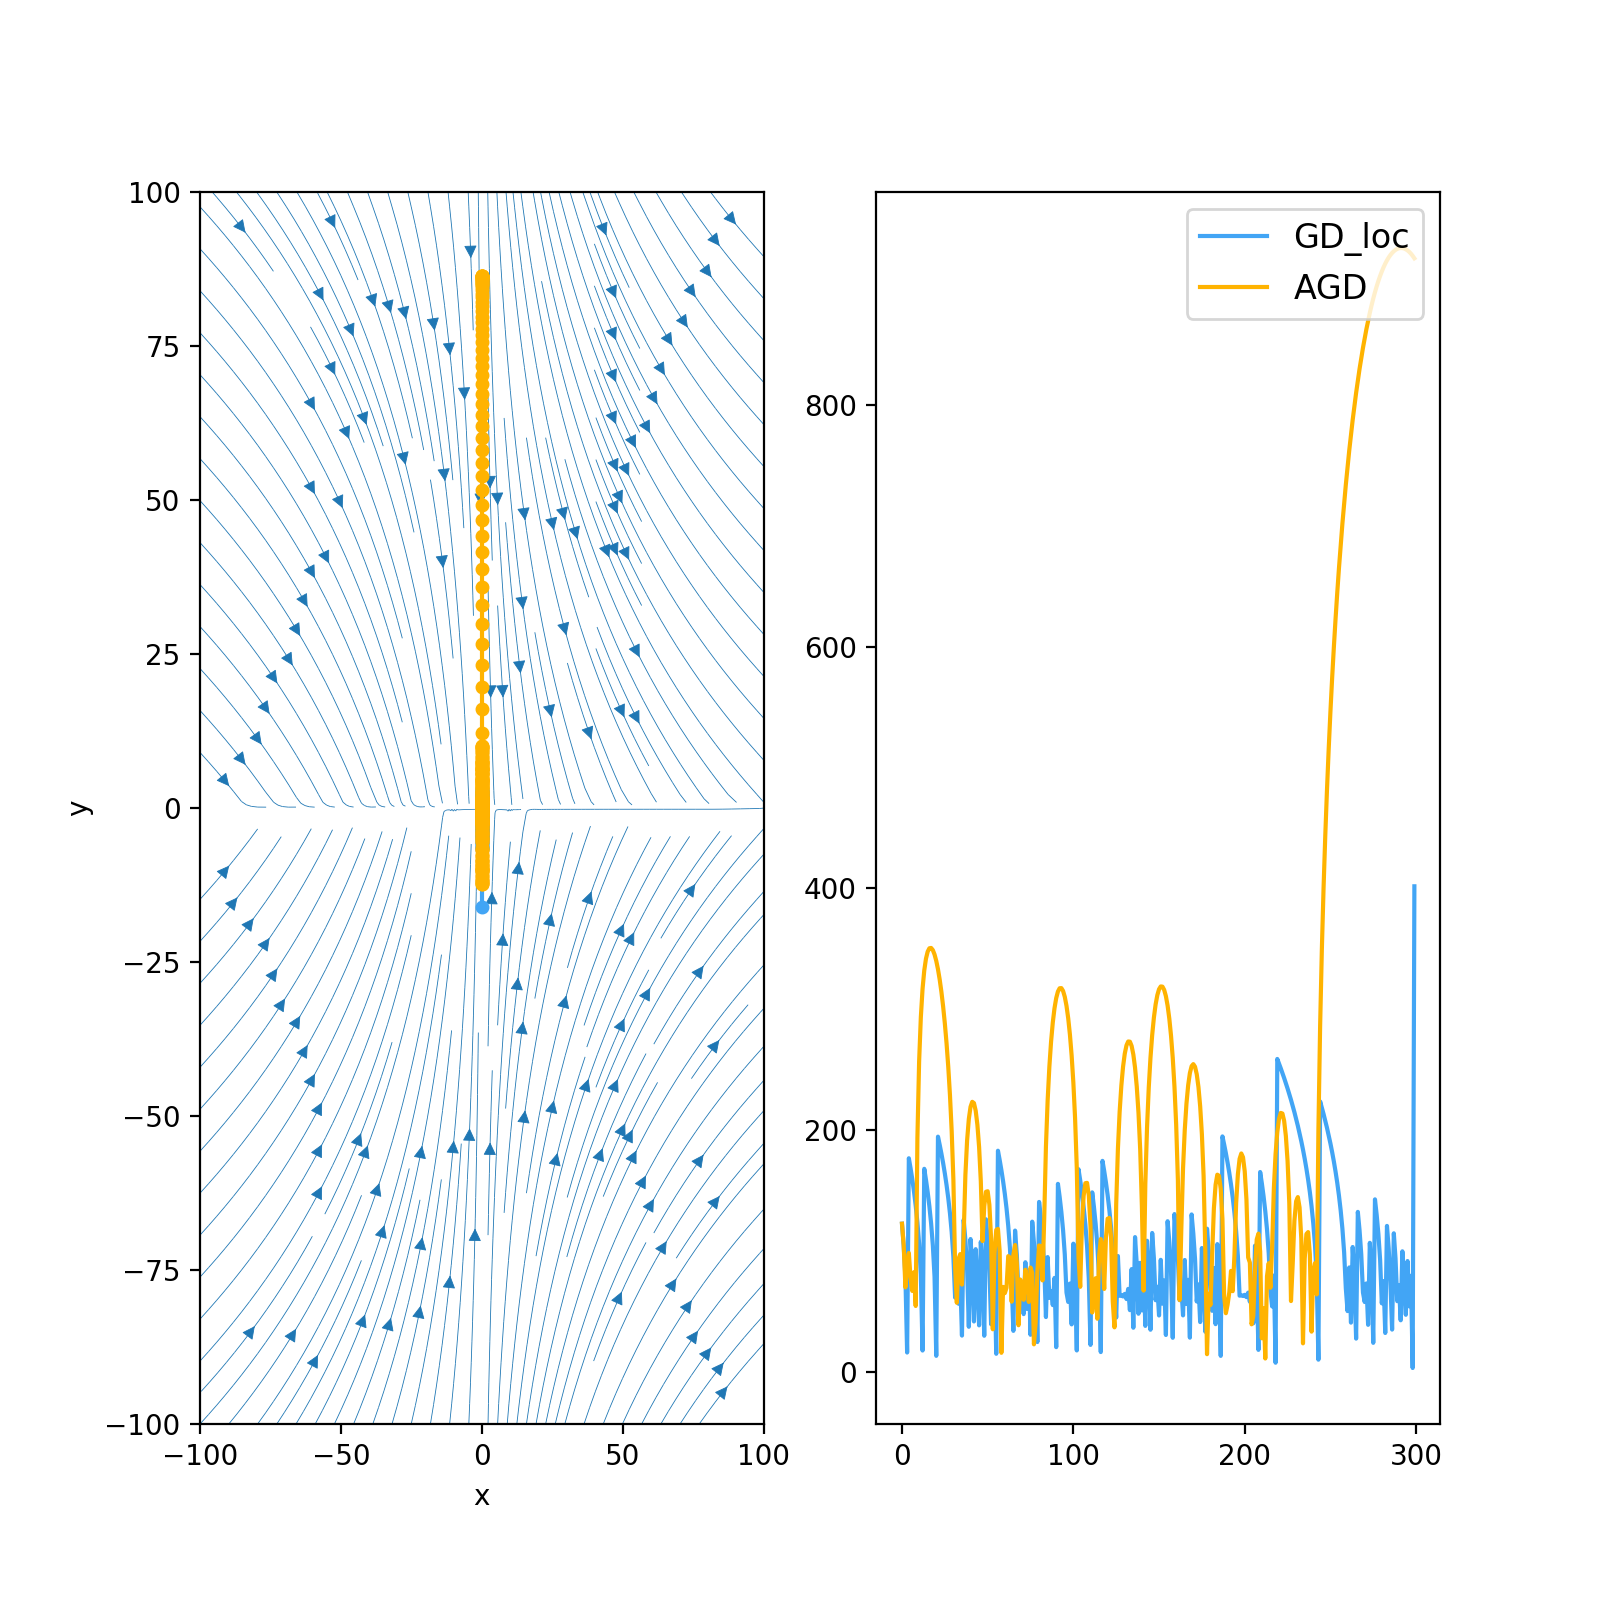

<IPython.core.display.Javascript object>


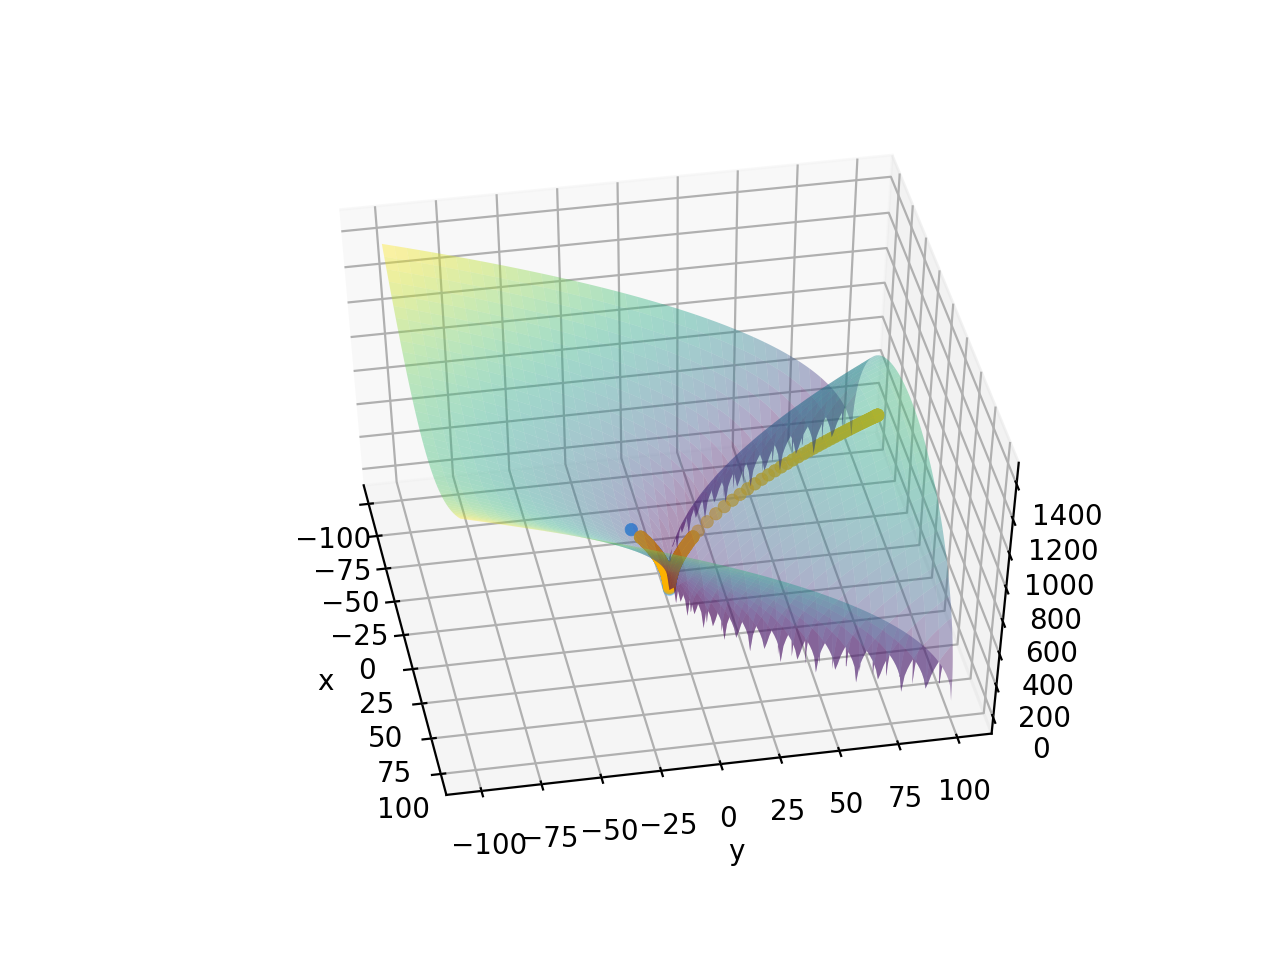

In [55]:
no_of_runs=1
iterations=300
accuracy=1e-10
step_size=1/100  #1/L for the quadratics


global loss_type
global log_loss
log_loss=False
#loss_type='coercive_saddle'
loss_type='tube'
loss_type='quadratic'
loss_type='rosenbrock'
loss_type='bunkin'
list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((-100,100))

GD=True
PGD=False
AGD=True
Momentum=False

x_0=0
y_0=2
w_0=np.array((x_0,y_0))

if GD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,y_0))
    if loss_type=='bunkin':
        w_0=np.array((x_0,1.5))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD_loc')
    list_steps.append(GD_steps)
    
    
if False:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD2_steps,_x,_loss)= Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD2_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD2_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD2_loss)
    list_x.append(GD2_x)
    list_methods.append('GD_glob')
    list_steps.append(GD2_steps)
 
if AGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)

if Momentum:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,-y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (Momentum_steps,_x,_loss)= Momentum(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    Momentum_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Momentum_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(Momentum_loss)
    list_x.append(Momentum_x)
    list_methods.append('Momentum')
    list_steps.append(Momentum_steps)

if PGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,-y_0))
    radius=0.05
    g_thres=0.2
    t_thres=1
    f_thres=-0.05  #if PGD ascends more than f_thres in t_thres iterations since pertubation->stop.
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        opt_gap=compute_loss(w_0)-(-1/4)
        (PGD_steps,_x,_loss)= Pertubed_Gradient_Descent(w_0,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius)
        loss_collector.append(_loss)
        x_collector.append(_x)
    PGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(PGD_loss)
    list_x.append(PGD_x)
    list_methods.append('PGD')
    list_steps.append(PGD_steps)    
    
make_plot(list_loss,list_x,list_methods,list_steps,limits)


### some necessary functions:

In [49]:
 def compute_loss(w):
    if loss_type=='coercive_saddle':
        loss=0.5*w[0]**2+1/4*w[1]**4-0.5*w[1]**2
    elif loss_type=='quadratic':
        loss=w[0]**2+5*w[1]**2
    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            loss=-gamma*w[0]**2+L*w[1]**2
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            loss=L*(w[0]-2)**2-gamma*w[1]**2
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            loss=L*(w[0]-2)**2+L*(w[1]-2)**2
        else:
            loss=0
    elif loss_type=='rosenbrock':
            loss = (1. - w[0]) ** 2 + 100. * (w[1] - w[0] ** 2) ** 2
    elif loss_type=='bunkin':
            loss=100 * np.sqrt(np.abs(w[1] - 0.01*w[0]**2)+0.000000001)+0.01 * np.abs(w[0]+10)
    else:
        raise ValueError("Unknown losstype!")
    
    return loss

def compute_gradients(w):
# forward pass

    if loss_type=='coercive_saddle':
        grad = np.array([w[0], w[1] ** 3 - w[1]])
    elif loss_type=='quadratic':
        grad = np.array([2*w[0],10*w[1]])

    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            grad = np.array([-2*gamma*w[0], 2*L* w[1]])
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            grad = np.array([2*L*(w[0]-2), -2*gamma* w[1]])
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            grad = np.array([2*L*(w[0]-2), 2*L*(w[1]-2)])
        else:
            grad=np.array([0,0])
    elif loss_type=='rosenbrock':
        grad = np.array([-2 + 2. * w[0] - 400 * w[0] * w[1] + 400 * w[0] ** 3, 200. * w[1] - 200 * w[0] ** 2])
        
    elif loss_type=='bunkin':
        c=50*(1/np.sqrt(np.abs(w[1]-0.01*w[0]**2)+0.000000001))
        #first dimension
        if w[0]>0:
            grad1=-0.02*w[0]*c+0.01
        elif w[0]<0:
            grad1=0.02*w[0]*c-0.01
        else:
            grad1=0
            
        #second dimension
        if w[1]>0:
            grad2=c
        elif w[1]<0:
            grad2=-c
        else:
            grad2=0
        
        grad=np.array([grad1,grad2])
    else:
        raise ValueError("Unknown losstype!")
        
    return grad



def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']
    if log_loss:
        #overall min value
        min_value=1000
        for k in range(len(list_loss)):
            min_value = min(list_loss[k]) if (min(list_loss[k])<=min_value) else min_value
        #subtract min value from all values and add epsilon
        eps = min_value*1e-6
        for k in range(len(list_loss)):
            list_loss[k]= [i - min_value+eps  for i in list_loss[k]]

    s=1
    x_ax = np.arange(limits[0],limits[1]+s, s)  
    y_ax = np.arange(limits[0],limits[1]+s, s)  
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    gradient_x=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_y=np.zeros((y_ax.shape[0],y_ax.shape[1]))
    loss=np.zeros((x_ax.shape[0],x_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
            grad=compute_gradients(np.array((x_ax[i,j],y_ax[i,j])))
            gradient_x[i,j]=grad[0]
            gradient_y[i,j]=grad[1]
            loss[i,j]=compute_loss(np.array((x_ax[i,j],y_ax[i,j])))


    #1. Plot Gradient Flow
    plt.subplot(1, 2, 1)
        
    plt.streamplot(x_ax,y_ax,-gradient_x,-gradient_y, density=2, linewidth='0.3')
    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('x')
    plt.ylabel('y')
    
    #Show iterates
    for i in range (len(list_loss)):
        plt.plot(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], '-o',color= colors[i],markersize='4',alpha=1)
    #plt.legend(list_methods,fontsize=12, loc=1)

    #2. Plot performance over time/steps
    plt.subplot(1, 2, 2)
    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)
    
    if log_loss:
        plt.yscale('log')
    else: 
        plt.yscale('linear')
    
    #3 .Plot Error Surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_ax, y_ax, loss,cmap='viridis', 
                    alpha=0.4,zorder=1)  
    # Show iterates
    for i in range(len(list_loss)):
        ax.scatter(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], list_loss[i],'o',color= colors[i],linewidth='0.25',zorder=i+2)

    plt.xlabel('x')
    plt.ylabel('y')



### Gradient Descent

In [5]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Accelerated Gradient Descent

In [51]:
#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        if loss_type=='quadratic':
            beta_k=(np.sqrt(10/2)-1)/(np.sqrt(10/2)+1)
        else:
            beta_k=(k-1)/(k+2)
        y=w+beta_k*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        if loss_type=='tube':
            if w[1]<0:
                w[1]=-w[1]
 
        if np.linalg.norm(grad)<accuracy:

            break

    return(iterates,x,loss)